In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD



# Latent matrix from metadata

In [137]:
df = pd.read_csv('data/2019_oct_sort_1000.csv')

In [138]:
df.shape

(1000, 9)

In [139]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [140]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-18 10:54:45 UTC,view,54900011,2146660887203676486,apparel.costume,NaN,64.35,515483062,00000042-3e3f-42f9-810d-f3d264139c50
1,2019-10-18 10:55:20 UTC,view,54900011,2146660887203676486,apparel.costume,NaN,64.35,515483062,00000042-3e3f-42f9-810d-f3d264139c50
2,2019-10-31 06:25:30 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.46,513782162,00000056-a206-40dd-b174-a072550fa38c
3,2019-10-31 06:25:52 UTC,view,5100816,2053013553375346967,NaN,xiaomi,29.60,513782162,00000056-a206-40dd-b174-a072550fa38c
4,2019-10-31 06:23:12 UTC,view,1005115,2053013555631882655,electronics.smartphone,apple,955.84,513782162,00000056-a206-40dd-b174-a072550fa38c


In [141]:
def preprocessing_feat(X, drop_event_time=False):
    if drop_event_time:
        X = X.drop("event_time", axis=1)
    
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')
    return X_preprocessed

In [142]:
X_preprocessed = preprocessing_feat(df,  drop_event_time=True)

/tmp/ipykernel_8059/4055017079.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')


In [143]:
X_preprocessed.shape

(445, 8)

## Pricing criterion

In [144]:
def make_column(row):
    if row["price"] < row["25%"]:
        return "low"
    elif row["price"] < row["75%"]:
        return "medium"
    else:
        return "high"

def pricing_criterion(X):
    pricing_guide = X.groupby('category_code')['price'].describe()[["25%", "75%"]].reset_index()
    X_merged = X.merge(pricing_guide, on="category_code", how="right")
    X_merged["price_category"] = X_merged.apply(lambda row: make_column(row), axis=1)
    return X_merged


In [145]:
X_merged = pricing_criterion(X_preprocessed)

In [146]:
def metadata(X):
    X['metadata'] = X[['category_code', 'brand', 'price_category']].apply(lambda x: ' '.join(x), axis = 1)
    return X


In [147]:
X_meta = metadata(X_merged)

In [148]:
X_meta.set_index(X_meta['product_id'], inplace=True)

In [149]:
print(X_meta.shape)
X_meta.head()

(445, 12)


,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,25%,75%,price_category,metadata
product_id,,,,,,,,,,,,
49800017,view,49800017,2126679654801604876,accessories bag,ritmix,12.32,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,low,accessories bag ritmix low
49800020,view,49800020,2126679654801604876,accessories bag,ritmix,15.43,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,medium,accessories bag ritmix medium
28401080,view,28401080,2053013566209917945,accessories bag,respect,66.67,516007189,000037a4-c043-4113-9b53-7bbb5d7c2bfe,13.8750,41.0500,high,accessories bag respect high
28719157,view,28719157,2116907519078040377,apparel shoes,salamander,127.42,532234792,00006cdc-ee07-41db-958a-232b53a1f4fd,72.5875,88.4875,high,apparel shoes salamander high
28717170,view,28717170,2053013565639492569,apparel shoes,respect,84.43,557816044,000097b7-14fd-4336-a0e6-c82c981f8817,72.5875,88.4875,medium,apparel shoes respect medium


### Count Vectorizer

In [150]:
count = CountVectorizer()
count_matrix = count.fit_transform(X_meta['metadata'])
count_df_1 = pd.DataFrame(count_matrix.toarray(), index=X_meta.product_id.tolist())
print(count_df_1.shape)
count_df_1.head()

(445, 170)


,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
49800017,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49800020,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28401080,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28719157,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28717170,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [151]:
count_df_1 = count_df_1.reset_index()

In [152]:
len(list(set(count_df_1.index)))#.nunique()

445

In [153]:
count_df_1.drop_duplicates(subset='index', keep='first', inplace=True) 
count_df_1["product_id"] = count_df_1["index"]
count_df_1.drop("index", axis=1, inplace=True)
count_df_1.head()

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,product_id
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49800017
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49800020
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28401080
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,28719157
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,28717170


### Dimensionality reduction

In [154]:
n = 50
svd = TruncatedSVD(n_components=n)
latent_df_1 = svd.fit_transform(count_df_1.set_index("product_id"))

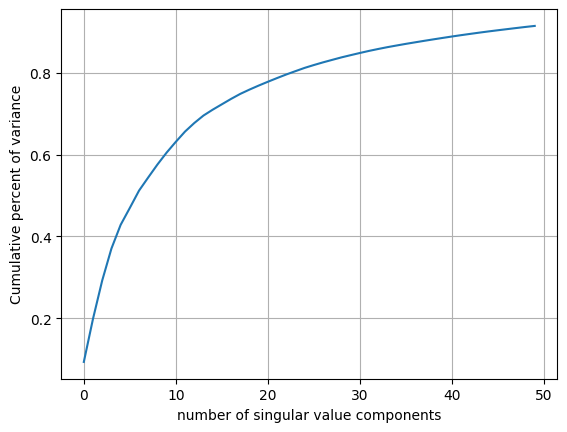

In [155]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [156]:
#count_df_1=count_df_1.set_index("product_id")
#count_df_1.head()
df_for_latent1 = count_df_1.product_id.tolist()

In [157]:
#n defined above
#n = 50
latent_df_1 = pd.DataFrame(latent_df_1[:,0:n], index=df_for_latent1)
print(latent_df_1.shape)
latent_df_1

(310, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
49800017,0.159126,0.094781,0.074467,0.867845,0.104342,0.451602,0.152625,-0.047068,0.053521,0.675642,...,-0.045675,0.009027,-0.000423,-0.012214,-0.022671,-0.048981,-0.008459,0.000452,-0.003054,0.006717
49800020,0.409155,-0.382170,0.576855,-0.308769,0.238508,0.484030,0.073801,0.038980,0.071821,0.701121,...,-0.056394,0.042384,0.001546,-0.004379,-0.023165,-0.050245,-0.006419,0.003228,0.004282,-0.017293
28401080,0.265688,0.819887,-0.069625,-0.261478,0.272532,0.385874,0.291194,0.005876,0.199421,0.596432,...,0.027652,-0.044212,-0.004153,-0.016692,-0.013140,-0.016901,0.004948,-0.000691,-0.002124,0.016427
28719157,0.274873,0.828929,-0.039082,-0.235706,0.326835,0.626002,0.366783,0.021173,0.926960,-0.465166,...,-0.035337,0.042619,0.012967,-0.011923,-0.021067,-0.010715,-0.013444,-0.015859,-0.027027,-0.017941
28717170,0.424708,-0.360599,0.624793,-0.291207,0.327407,0.838738,0.194364,0.061150,1.015400,-0.473332,...,0.066491,-0.048821,-0.008588,0.015983,0.023579,0.018682,0.007700,0.003866,0.014322,0.000412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901444,0.405871,-0.403868,0.573468,-0.335038,0.207657,0.363650,0.009501,0.043420,0.016501,0.069495,...,0.010239,-0.006366,-0.006660,0.018007,0.008052,-0.011719,0.013262,0.065589,-0.090868,0.036780
10400294,0.156276,0.073684,0.071730,0.851527,0.074652,0.338353,0.090313,-0.043913,-0.001854,0.045490,...,0.033784,-0.064493,-0.018968,0.027106,0.021800,-0.026424,-0.003596,0.120323,-0.209878,0.159163
10400334,0.406306,-0.403267,0.574117,-0.325087,0.208818,0.370782,0.011488,0.042135,0.016445,0.070969,...,0.023064,-0.031137,-0.016998,0.034940,0.021306,-0.027688,-0.001557,0.123099,-0.202542,0.135152
10400398,0.259958,0.803929,-0.085135,-0.281876,0.228669,0.213571,0.211477,0.002942,0.025685,0.052357,...,-0.015029,0.026283,0.007087,-0.029670,-0.042050,0.075914,-0.025987,-0.251190,0.512016,-0.083961


In [158]:
latent_df_1.reset_index().drop_duplicates().shape

(310, 51)

In [ ]:
#X_meta['product_id'].nunique()

# Latent matrix from event types

In [159]:
def preprocessing_event(X):
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    return X_preprocessed

In [160]:
df_event = preprocessing_event(df)

In [161]:
dct = {'view': 1, 'cart': 3, 'purchase': 5}

In [162]:
df_event['rating'] = df_event['event_type'].map(dct)

In [185]:
df_event["rating"].sum()

743

In [205]:
df_rating.shape

(310, 186)

In [197]:
df_rating = df_event.pivot_table(values='rating',
                                 index='product_id',
                                 columns='user_id',
                                 aggfunc="sum").fillna(0)
df_rating

user_id,512483064,512561891,512600925,512625864,512652590,512843699,512845701,512893095,513035269,513160929,...,563123464,563195675,563543861,563842008,564098956,564240719,564555327,564879838,565847508,566031240
product_id,,,,,,,,,,,,,,,,,,,,,
1002532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35200189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43300127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45300048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
df_rating.sum().reset_index()[0].sum()

743.0

In [199]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    743
dtype: int64

In [207]:
df_rating.reset_index()

user_id,product_id,512483064,512561891,512600925,512625864,512652590,512843699,512845701,512893095,513035269,...,563123464,563195675,563543861,563842008,564098956,564240719,564555327,564879838,565847508,566031240
0,1002532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1002540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1002544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1002633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,35200189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,43300127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307,45300048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,49800017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
svd = TruncatedSVD(n_components=75)
latent_df_2 = svd.fit_transform(df_rating)

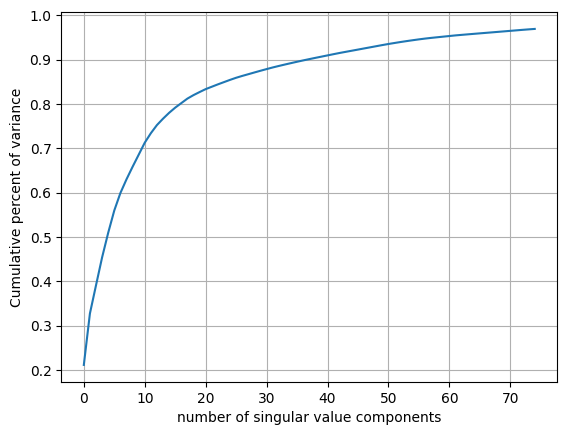

In [202]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [210]:
latent_df_2 = pd.DataFrame(latent_df_2, index=df_rating.reset_index().product_id.tolist())
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
1002532,-4.913825e-18,1.189277e-16,-4.492746e-15,-1.115406e-15,-1.470284e-15,-7.193301e-16,-5.162798e-15,6.748204e-15,-1.721837e-13,-5.988842e-13,...,-0.000073,0.000015,0.000054,0.000092,0.000146,0.000041,0.000047,-0.000185,-0.000074,-0.000146
1002540,-5.792057e-18,2.442122e-16,3.205406e-16,6.366287e-17,1.884259e-16,1.047555e-16,-4.787222e-16,-4.652865e-15,2.110443e-14,4.242405e-14,...,0.000007,-0.000001,-0.000006,-0.000009,-0.000016,-0.000005,-0.000006,0.000020,0.000008,0.000015
1002542,2.123614e-04,4.223970e-08,4.263943e-14,2.330092e-14,7.880615e-14,-5.249881e-06,-1.802384e-04,-3.229929e-06,9.362643e-13,-8.502271e-08,...,0.000050,0.000324,0.000126,-0.000516,-0.000857,-0.000878,-0.001903,0.001705,0.001614,0.000873
1002544,5.367606e+00,-4.998541e-04,9.388104e-14,-6.122810e-14,-6.049845e-14,5.030703e-01,4.515955e+00,1.861108e-01,7.392190e-12,-6.335104e-03,...,-0.000129,-0.001182,0.000666,0.001065,0.001465,0.002634,-0.003783,0.005658,-0.028993,-0.005208
1002633,7.973937e-02,8.646383e-06,2.342091e-14,1.303059e-14,4.281305e-14,-4.689849e-04,-1.237798e-02,-1.750773e-04,1.411886e-13,-4.074833e-06,...,0.000054,0.000295,0.000114,-0.000242,-0.000398,-0.000606,-0.000808,0.000491,0.001301,-0.000031


In [211]:
latent_df_2.shape

(310, 75)